<a href="https://colab.research.google.com/github/michael-borck/ISYS2001/blob/main/enron_staff_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enron Email Analysis

## Executive Summary

Enron had several significant peaks in e-mail traffic. The most prominent peaks and heaviest traffic occurred in October and November 2001, when the scandal broke. The next most notable was in June 2001, involving Enron and the California energy crisis. The Top 10 emailers account for 15.83% of messages and should be analysed further.



## Introduction

This notebook is an initial investigation into Enron emails.  It uses the publicly available Enron e-mail dataset. This is a very famous dataset consisting of e-mail messages sent to, from, and between employees working at the now-defunct Enron Corporation. As part of the U.S. Government investigation into accounting fraud at Enron, the e-mails became part of the public record and are now downloadable by anyone. 

This report will focus on two areas:

* the volume of daily emails
* who were the greatest communicators

We will only consider emails sent whilst Enron was a legal entity which was between 1 July 1985 and 2nd November 2001 (Wikipedia, 2022)

## Data Source

The MySQL Enron corpus was provided as a SQLite3 database (Borck 2022).

## Report Format

This report is provided as an interactive notebook.  It is designed to run on the Google Colab environment.  You can either read the report as provided or inspect and rerun the code alowing you to verify the analysis.

## Analysis


### Daily Message Count

Initial explorations of the data showed that numerous e-mails had incorrect dates, for example, there are a number of dates that seem to predate or postdate the existence of the corporation (for example, 1979) or that were from years that were illogical (for example, 0001 or 2044). The Table 1 shows an a few of the weird lines. All of these dates are formatted correctly; however, some of the dates are definitely wrong:

In [1]:
#@title Table 1

# import the require packages
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import os
from IPython.display import clear_output 


# Copy the Enron Email database
if not os.path.exists('enron.db'):
  !wget -O enron.db https://curtin-my.sharepoint.com/:u:/g/personal/211934g_curtin_edu_au/EaYagsqa2r1Bi5wtHbswGFwBH2kd2uTnz6rlka7GI36GUQ?download=1
  clear_output()
  print('Copied Enron database')

 
# connect to the database
con = sqlite3.connect('enron.db')
 
# create a variable to store the query
SQL = '''
    SELECT date(date) AS date_sent, count(mid) AS message_count
        FROM message
        GROUP BY date_sent
        ORDER BY date_sent;
'''
 
# Load the query into a dataframe
df = pd.read_sql(SQL, con)
df

Copied Enron database


,date_sent,message_count
0,0001-05-30,2
1,0001-06-18,1
2,0001-07-24,1
3,0001-08-01,1
4,0001-08-06,1
...,...,...
1318,2020-12-24,1
1319,2020-12-29,1
1320,2043-12-28,1
1321,2044-01-02,1


Figure 1 is a plot of the number of messages per filtered by a date range.

In [42]:
#@title Table 2 - Days with Message Count greater 1500

start_date = '1984-04-01' #@param {type:"date"}
end_date = '2002-11-01' #@param {type:"date"}

#greater than the start date and smaller than the end date
mask = (df['date_sent'] > start_date) & (df['date_sent'] <= end_date)

selected_df = df[mask] 

selected_df[selected_df['message_count'] > 1500]

,date_sent,message_count
1068,2001-10-18,1624
1072,2001-10-22,2025
1073,2001-10-23,1763
1074,2001-10-24,1936
1075,2001-10-25,2207
1076,2001-10-26,1978
1079,2001-10-29,2180
1100,2001-11-19,1909
1101,2001-11-20,1723
1107,2001-11-26,2031


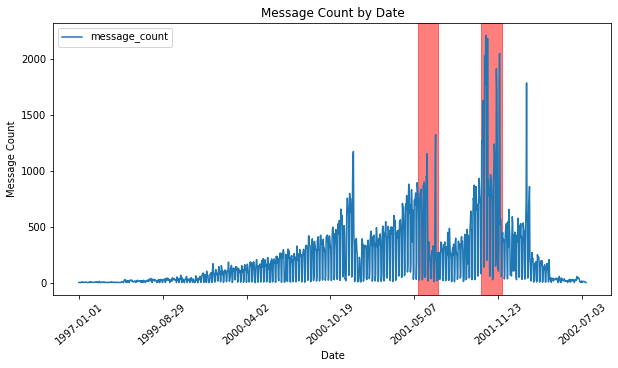

In [142]:
#@title Figure 1 - Message Count by Day

# Plot the date_df
ax = selected_df.plot(x = 'date_sent', 
        y = 'message_count',
        title = 'Message Count by Date',
        xlabel = 'Date',
        ylabel = 'Message Count',
        figsize = (10,5)
        )

# Rotate and Name the Title and Labels
plt.xticks(rotation=40) #, horizontalalignment="center")

# Print bands on chart to highlight busy periods
# https://stackoverflow.com/a/8271438
# Find start-end point based
start = selected_df.index[selected_df['date_sent'] == '2001-02-01'][0]
end = selected_df.index[selected_df['date_sent'] == '2001-03-20'][0]
ax.axvspan(start,end,alpha=0.5, color='red')

# Scandal Broke Novemebr 2001
start = selected_df.index[selected_df['date_sent'] == '2001-07-01'][0]
end = selected_df.index[selected_df['date_sent'] == '2001-08-20'][0]
ax.axvspan(start,end,alpha=0.5, color='red')
clear_output() 

### Prominent Emailers

We identify the top 10 emailers in the company, we will first find the top 10 email address.  Then using these, mfind out their real names.  Then we will plot the top 10 emailers.


In [146]:
#@title Table 3 - Top Email Addresses

# create a variable to store the query
SQL = '''
  SELECT sender, count(mid) AS message_count
    FROM message
    GROUP BY sender
    ORDER BY message_count;
'''
 
# Load the query into a dataframe
df = pd.read_sql(SQL, con)
df.tail(14)

Total Messages:  252759


,sender,message_count
17513,james.d.steffes@enron.com,2161
17514,gerald.nemec@enron.com,2275
17515,steven.j.kean@enron.com,2278
17516,pete.davis@enron.com,2500
17517,debra.perlingiere@enron.com,2549
17518,matthew.lenhart@enron.com,2784
17519,enron.announcements@enron.com,2838
17520,no.address@enron.com,3511
17521,chris.germany@enron.com,3686
17522,tana.jones@enron.com,4437


## Finding Names

We will use the employeeList table to find the names.  The email address announcements@enron.com and no.address@enron.com are generic emails and will be ignored.  The email peter.davis@enron.com has many messages but does not exist in the employee list table and will be ignored.  This discrepancy requires further investigation.

Total Messages: 252759
Top 10 Message Count 40017
Proportion  15.83%


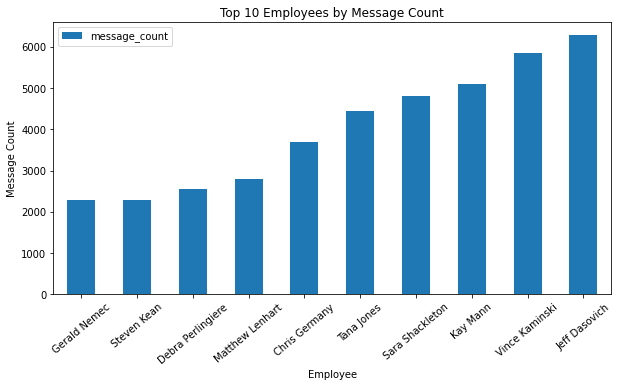

In [155]:
#@title Figure 2 - Top 10 Employees by Message Count

# Create a variable to store the query
SQL = '''
  SELECT * FROM employeeList;
'''
em_df = pd.read_sql(SQL, con)

# Three emails address not in employeeList, so grab last 13
top10_df = df.tail(13).rename(columns = {'sender':'Email_id'})

# merge
names = pd.merge(top10_df, em_df)

# add column for full name
names['full_name'] = names['firstName'] + ' ' + names['lastName']

# extract columns want to plot
names = names[['full_name','message_count']]

names.plot(x ='full_name',
           y = 'message_count',
           title = 'Top 10 Employees by Message Count',
           xlabel = 'Employee',
           ylabel = 'Message Count',
           figsize = (10,5),
           kind='bar')

# Rotate and Name the Title and Labels
plt.xticks(rotation=40) #, horizontalalignment="center")
clear_output()

total_messages = df['message_count'].sum()
total_top10 = names['message_count'].sum()
print(f'Total Messages: {total_messages}' )
print(f'Top 10 Message Count {total_top10}')
print(f'Proportion  {(total_top10 / total_messages) * 100:.2f}%')

## Discussion

Figure 1 shows Enron had several significant peaks in e-mail traffic. The largest peaks and heaviest traffic occurred in the October and November of 2001, when the scandal broke. The next largest June 2001 involving Enron California energy crisis.

The Top 10 emailers account for 15.83% of messages. Figure 2 shows the top 10 employees. It would be interesting to analyse the messages of these employees. For example conduct a sentiment analysis of each employeer.





# References

Borck, M, “ISYS2001-assignment/download_enron_data.ipynb at main · Michael-Borck/ISYS2001-assignment,” GitHub, 05-May-2022. [Online]. Available: https://github.com/michael-borck/isys2001-assignment/blob/main/download_enron_data.ipynb. [Accessed: 20-May-2022] 

Google Colab, “Google Colaboratory Forms”. [Online]. Available: https://colab.research.google.com/notebooks/forms.ipynb. [Accessed: 20-May-2022] 

Wikipedia, “Enron,” 20-May-2022. [Online]. Available: https://en.wikipedia.org/wiki/Enron. [Accessed: 20-May-2022] 

Joe Kington, “How to highlight specific x-value ranges,” Stack Overflow, Nov 25, 2011. [Online]. Available: https://stackoverflow.com/a/8271438. [Accessed: 20-May-2022] 